# <center>NoBias Hyperplay</center>

This file is an interactive notebook to analyze the data obtained from tests.<br>
The purpose of this notebook is to define a baseline for a model which can be improved upon.
The game blind_breakthrough will be used since this seems to be the game the original hyperplay model performed the best at.

**Note: It could be a good idea to look into using a stronger cheat agent for a better comparison**

## Reading in the Data

First the match data must be read in.
I will be reading in data obtained for a series of games where a hyperplayer with increasing resources competed against a CHEAT player who had access to the true state and was allowed 16 simulations per move.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics
np.random.seed(42)

# Read in the csv files
numNames = ['2x2', '4x4', '8x8']
data = list()

for idx, name in enumerate(numNames):
    file_name = '../testOutput/opponentModellingBASELINE/ophyper_resources/blind_breakthrough_6x6/' + name + '/testOutput.csv'
    data.append(pd.DataFrame)
    data[idx] = pd.read_csv(file_name, header=0)

# Read in the csv files
numNames = ['2x2', '4x4', '8x8']
data_ahyper = list()

for idx, name in enumerate(numNames):
    file_name = '../testOutput/recreatingResultsBASELINE/hyperplay_resources/blind_breakthrough_6x6/' + name + '/testOutput.csv'
    data_ahyper.append(pd.DataFrame)
    data_ahyper[idx] = pd.read_csv(file_name, header=0)
    
# Print the first 5 rows of the data
for game in data:
    display(game.head())

,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598337631570,10,300,WHITE,30,white,OPHYPER,0,black,CHEAT,100
1,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598337939942,10,300,WHITE,42,white,OPHYPER,0,black,CHEAT,100
2,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598338284098,10,300,WHITE,44,white,OPHYPER,0,black,CHEAT,100
3,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598338364923,10,300,WHITE,14,white,OPHYPER,0,black,CHEAT,100
4,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598338515942,10,300,WHITE,35,white,OPHYPER,100,black,CHEAT,0


,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598338083540,10,300,WHITE,37,white,OPHYPER,100,black,CHEAT,0
1,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598338434038,10,300,WHITE,41,white,OPHYPER,100,black,CHEAT,0
2,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598339220331,10,300,WHITE,36,white,OPHYPER,0,black,CHEAT,100
3,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598340173579,10,300,WHITE,41,white,OPHYPER,100,black,CHEAT,0
4,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598340739634,10,300,WHITE,44,white,OPHYPER,50,black,CHEAT,50


,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598337495786,10,300,WHITE,7,white,OPHYPER,100,black,CHEAT,0
1,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598337941132,10,300,WHITE,46,white,OPHYPER,0,black,CHEAT,100
2,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598338083658,10,300,WHITE,9,white,OPHYPER,100,black,CHEAT,0
3,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598338609051,10,300,WHITE,34,white,OPHYPER,0,black,CHEAT,100
4,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,1598339070445,10,300,WHITE,26,white,OPHYPER,0,black,CHEAT,100


Next, the move data should be read in for each match

*Note: time_to_update and time_to_select_move are in milliseconds*

In [2]:
move_list_games = list()
for idx, name in enumerate(numNames):
    file_name_prefix = '../testOutput/opponentModellingBASELINE/ophyper_resources/blind_breakthrough_6x6/' + name + '/moveset/'
    temp_move_list = list()
    for match_name in data[idx]['match_id']:
        file_name = file_name_prefix + match_name + '.csv'
        temp_move_list.append(pd.read_csv(file_name, names=['match_id','game_name','step','role_name','player_name','count_hypergames','num_probes','time_to_update','time_to_select_move','move_chosen','last_move_illegal','num_sims','num_forward_calls']))
    move_list_games.append(temp_move_list)

move_list_games_ahyper = list()
for idx, name in enumerate(numNames):
    file_name_prefix = '../testOutput/recreatingResultsBASELINE/hyperplay_resources/blind_breakthrough_6x6/' + name + '/moveset/'
    temp_move_list = list()
    for match_name in data_ahyper[idx]['match_id']:
        file_name = file_name_prefix + match_name + '.csv'
        temp_move_list.append(pd.read_csv(file_name, names=['match_id','game_name','step','role_name','player_name','count_hypergames','num_probes','time_to_update','time_to_select_move','move_chosen','last_move_illegal']))
    move_list_games_ahyper.append(temp_move_list)
    
# Verify by printing the head of the first game
for move_list in move_list_games:
    display(move_list[0])

,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen,last_move_illegal,num_sims,num_forward_calls
0,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,0,WHITE,ophyper,1,2,31,2935,(MOVE 5 2 5 3 ),False,12,0
1,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,0,BLACK,cheat,1,16,20,3050,NOOP,False,15,0
2,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,1,WHITE,ophyper,1,2,1282,0,NOOP,False,8,1
3,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,1,BLACK,cheat,1,16,65,5861,(MOVE 1 5 1 4 ),False,90,6
4,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,BLACK,cheat,1,16,6,1778,NOOP,False,15,1
5,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,WHITE,ophyper,2,2,3765,1583,(MOVE 3 2 3 3 ),False,76,4
6,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,3,WHITE,ophyper,2,2,1932,0,NOOP,False,16,2
7,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,3,BLACK,cheat,1,16,18,6806,(MOVE 2 5 2 4 ),False,105,3
8,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,4,BLACK,cheat,1,16,10,1812,NOOP,False,15,1
9,blind_breakthrough_6x6_CHEAT_2x2ophyper_16chea...,blind_breakthrough_6x6_CHEAT,4,WHITE,ophyper,2,2,7154,1617,(MOVE 3 3 2 4 ),False,154,3


,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen,last_move_illegal,num_sims,num_forward_calls
0,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,0,BLACK,cheat,1,16,6,3621,NOOP,False,15,0
1,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,0,WHITE,ophyper,1,4,28,4046,(MOVE 6 2 6 3 ),False,24,0
2,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,1,WHITE,ophyper,1,4,1419,0,NOOP,False,8,1
3,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,1,BLACK,cheat,1,16,76,7733,(MOVE 4 5 4 4 ),False,90,6
4,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,BLACK,cheat,1,16,10,1924,NOOP,False,15,1
5,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,WHITE,ophyper,4,4,4540,7609,(MOVE 1 2 1 3 ),False,156,8
6,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,3,WHITE,ophyper,4,4,4208,0,NOOP,False,32,4
7,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,3,BLACK,cheat,1,16,25,9253,(MOVE 2 5 2 4 ),False,105,4
8,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,4,BLACK,cheat,1,16,2,1513,NOOP,False,15,1
9,blind_breakthrough_6x6_CHEAT_4x4ophyper_16chea...,blind_breakthrough_6x6_CHEAT,4,WHITE,ophyper,4,4,14596,7877,(MOVE 4 2 4 3 ),False,352,11


,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen,last_move_illegal,num_sims,num_forward_calls
0,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,0,BLACK,cheat,1,16,29,3278,NOOP,False,15,0
1,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,0,WHITE,ophyper,1,8,18,5193,(MOVE 5 2 5 3 ),False,48,0
2,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,1,WHITE,ophyper,1,8,1403,0,NOOP,False,8,1
3,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,1,BLACK,cheat,1,16,12,6102,(MOVE 4 5 4 4 ),False,90,1
4,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,BLACK,cheat,1,16,2,1824,NOOP,False,15,1
5,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,2,WHITE,ophyper,1,8,3795,3416,(MOVE 5 3 5 4 ),False,112,9
6,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,3,WHITE,ophyper,1,8,832,0,NOOP,False,8,5
7,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,3,BLACK,cheat,1,16,24,5653,(MOVE 2 5 2 4 ),False,105,4
8,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,4,BLACK,cheat,1,16,4,1649,NOOP,False,15,1
9,blind_breakthrough_6x6_CHEAT_8x8ophyper_16chea...,blind_breakthrough_6x6_CHEAT,4,WHITE,ophyper,3,8,3787,7550,(MOVE 5 4 6 5 ),False,224,21


## Analysis of Data

### Overall Agent Results

The average score of the agent will be calculated across all games

The win/draw rate for the agent "OPHYPER" playing the game "blind_breakthrough_6x6_CHEAT" with 2x2 probes is 18.00% for 100 games
The win/draw rate for the agent "OPHYPER" playing the game "blind_breakthrough_6x6_CHEAT" with 4x4 probes is 39.00% for 100 games
The win/draw rate for the agent "OPHYPER" playing the game "blind_breakthrough_6x6_CHEAT" with 8x8 probes is 59.00% for 100 games


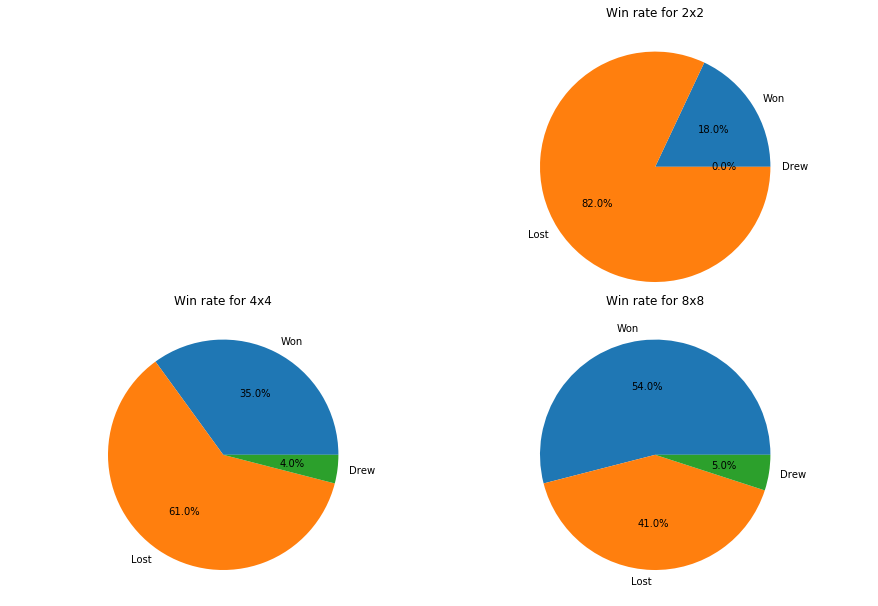

In [3]:
count_games_completed = list()
total_score_ophyper = list()
for idx, game in enumerate(data):
    total_score = data[idx]['player_1_score'][data[idx]['player_1_score'] >= 50].count() * 100
    total_count = len(data[idx]['player_1_score'])
    count_games_completed.append(total_count)
    total_score_ophyper.append(total_score)
    print(f"The win/draw rate for the agent \"" + str(data[idx]['player_1'][0]) + "\" playing the game \"" + str(data[idx]['game_name'][0]) + "\" with " + str(numNames[idx]) + f" probes is {(total_score/total_count):.2f}% for " + str(total_count) + " games")

# calc results for ahyper
win_count_ahyper = list()
total_score_ahyper = list()
for idx, game in enumerate(data_ahyper):
    total_score = data_ahyper[idx]['player_1_score'][data_ahyper[idx]['player_1_score'] >= 50].count() * 100
    total_score_ahyper.append(total_score)
    game_count = [len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)]), len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)]), len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)| (game['player_1_score'] == 50) & (game['player_2_score'] == 50)])]
    win_count_ahyper.append(game_count[0])
    
# Display a pie chart
fig = plt.figure()
data_len = len(data)
win_count = list()
for idx, game in enumerate(data):
    ax = fig.add_axes([(data_len - idx)%2,math.ceil((data_len - idx)/2),1,1])
    ax.axis('equal')
    ax.set_title('Win rate for ' + str(numNames[idx]))
    result = ['Won', 'Lost', 'Drew']
    game_count = [len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)]), len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)]), len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)| (game['player_1_score'] == 50) & (game['player_2_score'] == 50)])]
    win_count.append(game_count[0])
    ax.pie(game_count, labels = result,autopct='%1.1f%%')
plt.show()

It is now worth looking into how performance degrades with fewer probes.

First I will consider the number of games that can be completed without error compared to the number of probes.

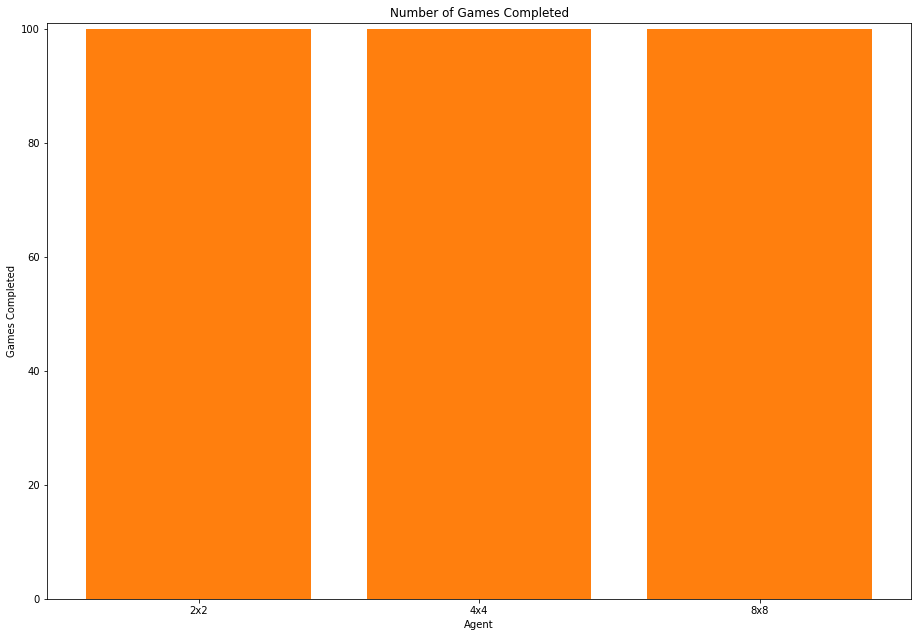

In [4]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2], label='state_update')
ax1.set_title('Number of Games Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Completed')
ax1.set_yscale('linear')
ax1.set_ylim([0,101])
ax1.bar(numNames, count_games_completed, color=u'#ff7f0e')
plt.show()

I will now consider whether the number of games won

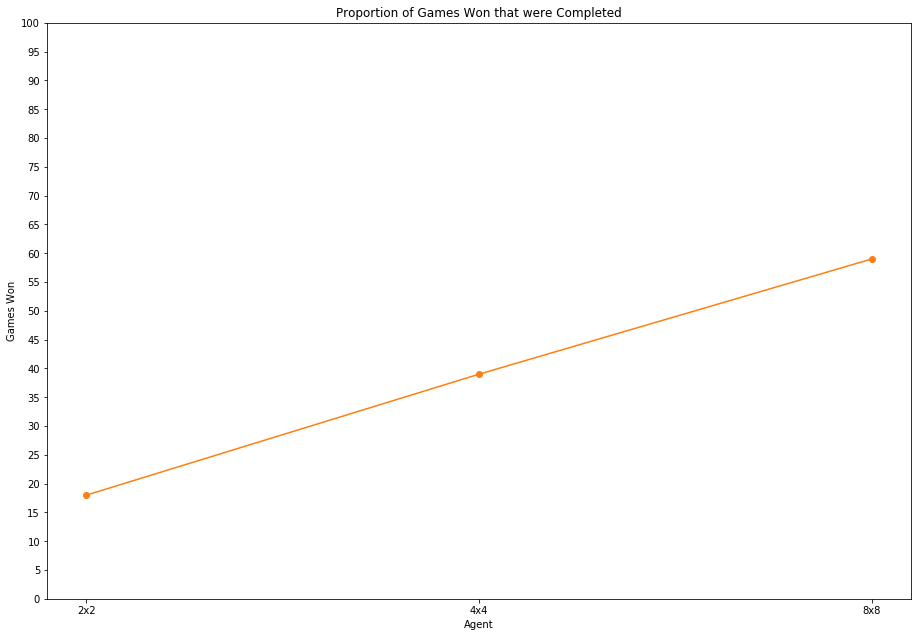

In [6]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Proportion of Games Won that were Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Won')
ax1.set_yscale('linear')
ax1.set_yticks(np.linspace(0, 100, 21))
ax1.set_ylim([0,100])
nobias_line, = ax1.plot(numNames, np.divide(total_score_ophyper,count_games_completed), marker='o', color=u'#ff7f0e')
plt.show()

Compared to ahyperlt

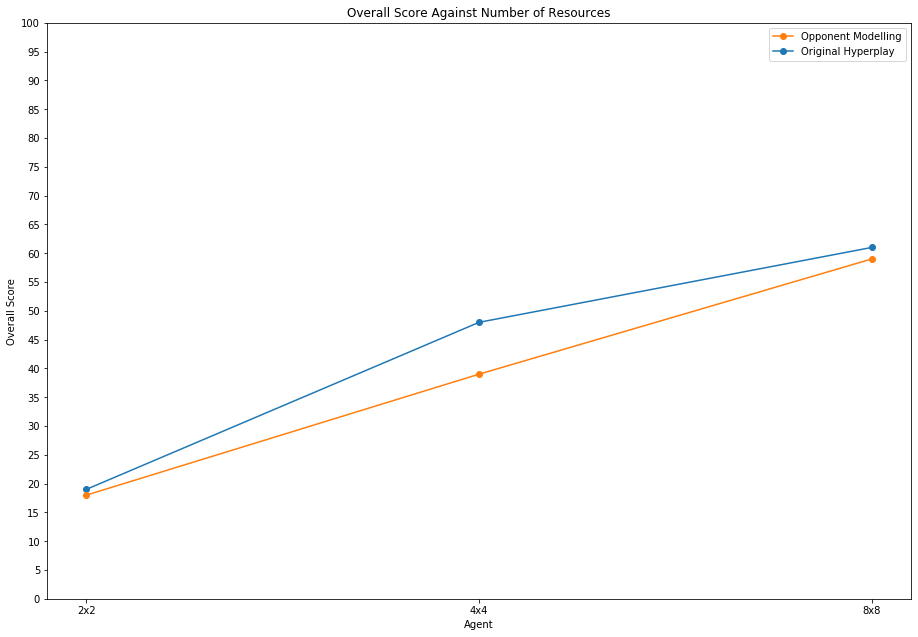

In [17]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Overall Score Against Number of Resources')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Overall Score')
ax1.set_yscale('linear')
ax1.set_yticks(np.linspace(0, 100, 21))
ax1.set_ylim([0,100])
ahyper_line, = ax1.plot(numNames, np.divide(total_score_ahyper,count_games_completed), marker='o')
nobias_line, = ax1.plot(numNames, np.divide(total_score_ophyper,count_games_completed), marker='o')
ax1.legend((nobias_line, ahyper_line), ('Opponent Modelling', 'Original Hyperplay'))
plt.show()

### Move Results

Calculating the average move time per game.
This is expected to grow with the depth of the game and is expected to be different for the state update and the move selection.

In [9]:
class Tracker:
    '''
    Tracker tracks the average time for each move of each game played
    '''
    def __init__(self):
        self.time_sum = 0
        self.num_moves = 0
        self.times = list()
    
    def __str__(self):
        return "time_sum: " + str(self.time_sum) + " ms\n\tnum_moves: " + str(self.num_moves) + "\n\tmean_time: " + str(statistics.mean(self.times)) + "\n\tmedian_time: " + str(statistics.median(self.times)) + " ms\n\ttimes (ms): " + str(self.times)
    
    def addMove(self, num):
        self.time_sum += num
        self.num_moves+=1
        self.times.append(num)
    
    def getMeanTime(self):
        return statistics.mean(self.times)
    
    def getMedianTime(self):
        return statistics.median(self.times)

# Add the results for each move of each game played to a list of trackers for the update and select move times for the chosen player
time_to_update_list = list()
time_to_select_move_list = list()
max_num_steps = [0] * len(numNames)
for idx, (move_list, game) in enumerate(zip(move_list_games, data)):
    temp_time_to_update_list = list()
    temp_time_to_select_move_list = list()
    player_name = game['role_1'][0].upper()
    for move_set in move_list:
        for index, move_row in move_set.iterrows():
            if move_row['role_name'] == player_name:
                if move_row['step'] > len(temp_time_to_update_list) - 1:
                    max_num_steps[idx] += 1
                    temp_time_to_update_list.append(Tracker())
                    temp_time_to_select_move_list.append(Tracker())
                temp_time_to_update_list[move_row['step']].addMove(move_row['time_to_update'])
                temp_time_to_select_move_list[move_row['step']].addMove(move_row['time_to_select_move'])
    time_to_update_list.append(temp_time_to_update_list)
    time_to_select_move_list.append(temp_time_to_select_move_list)

# Print the data
for game_num, (game_time_to_update_list, game_time_to_select_move_list) in enumerate(zip(time_to_update_list, time_to_select_move_list)):
    print(str(numNames[game_num]))
    for idx, (update_step, select_step) in enumerate(zip(game_time_to_update_list, game_time_to_select_move_list)):
        print('\tStep: ' + str(idx) + "\n")
        print('\tTime taken to update states:')
        print('\t' + str(update_step)  + "\n")
        print('\tTime taken to select move:')
        print('\t' + str(select_step)  + "\n\n\n")

2x2
	Step: 0

	Time taken to update states:
	time_sum: 2929 ms
	num_moves: 100
	mean_time: 29.29
	median_time: 29.0 ms
	times (ms): [31, 17, 21, 21, 21, 21, 31, 38, 26, 29, 41, 31, 26, 22, 36, 15, 35, 33, 30, 32, 23, 28, 27, 32, 31, 22, 31, 14, 18, 35, 34, 19, 33, 30, 34, 31, 35, 21, 39, 26, 28, 32, 27, 26, 38, 24, 36, 39, 25, 21, 29, 30, 26, 22, 35, 51, 35, 28, 27, 25, 47, 23, 29, 31, 24, 26, 43, 33, 38, 25, 22, 27, 28, 36, 27, 37, 34, 38, 38, 34, 33, 29, 28, 23, 19, 22, 26, 32, 32, 20, 29, 28, 31, 35, 33, 28, 31, 18, 26, 42]

	Time taken to select move:
	time_sum: 295220 ms
	num_moves: 100
	mean_time: 2952.2
	median_time: 2938.0 ms
	times (ms): [2935, 3002, 3222, 3276, 3208, 2837, 3020, 2915, 2913, 3153, 2685, 3135, 3101, 3043, 2849, 3241, 2955, 3097, 3198, 2930, 2438, 3007, 2586, 2924, 2825, 2831, 3189, 2858, 2941, 2946, 3085, 2934, 2975, 3293, 2797, 3085, 3039, 3083, 2670, 2898, 3298, 3104, 3307, 2920, 3100, 3087, 2904, 2869, 3359, 2898, 3090, 3082, 2730, 3107, 3026, 2819, 3446, 29

Now I will graph the findings

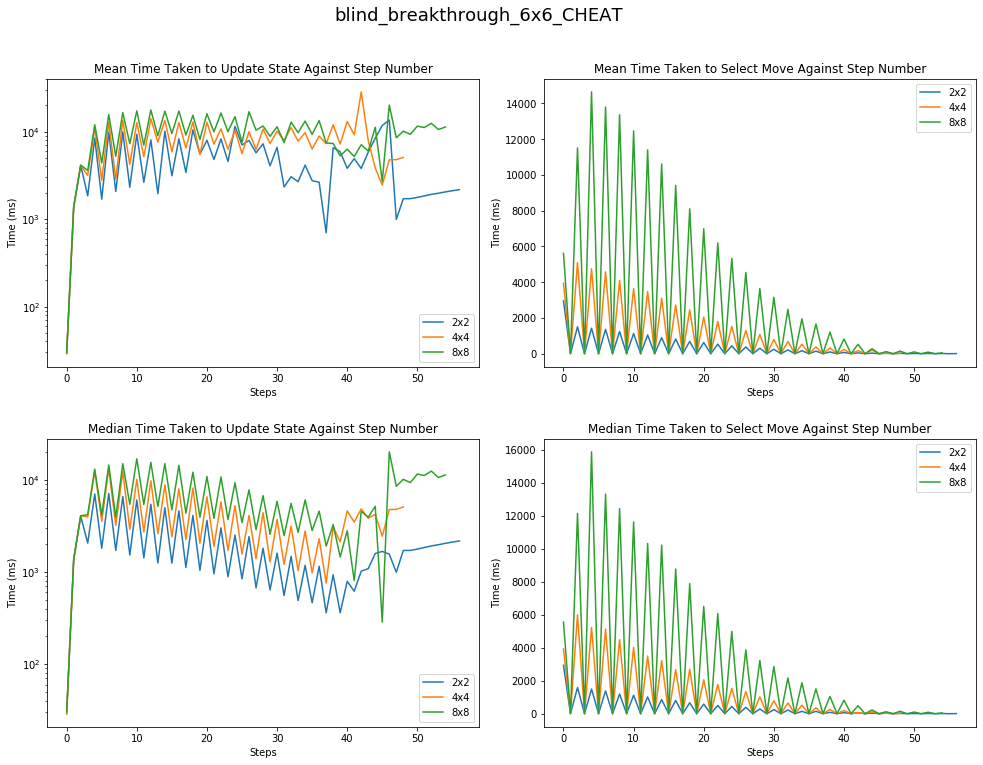

In [10]:
# Add the data to an array
mean_state_update_times = list()
mean_move_select_times = list()
median_state_update_times = list()
median_move_select_times = list()
for game_num, (game_time_to_update_list, game_time_to_select_move_list) in enumerate(zip(time_to_update_list, time_to_select_move_list)):
    temp_mean_state_update_times = list()
    temp_mean_move_select_times = list()
    temp_median_state_update_times = list()
    temp_median_move_select_times = list()
    for update_step, select_step in zip(game_time_to_update_list, game_time_to_select_move_list):
        temp_mean_state_update_times.append(update_step.getMeanTime())
        temp_mean_move_select_times.append(select_step.getMeanTime())
        temp_median_state_update_times.append(update_step.getMedianTime())
        temp_median_move_select_times.append(select_step.getMedianTime())
    mean_state_update_times.append(temp_mean_state_update_times)
    mean_move_select_times.append(temp_mean_move_select_times)
    median_state_update_times.append(temp_median_state_update_times)
    median_move_select_times.append(temp_median_move_select_times)

# Put into graphs
fig = plt.figure()
fig.suptitle(str(data[0]['game_name'][0]), x=1, y=2.5, fontsize=18)

# Draw mean graph for State Update
ax1 = fig.add_axes([0,1.25,1,1], label='state_update_mean')
ax1.set_title('Mean Time Taken to Update State Against Step Number')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Time (ms)')
ax1.set_yscale('log')
for idx, game_mean_state_update_times in enumerate(mean_state_update_times):
    ax1.plot(game_mean_state_update_times, label=str(numNames[idx]))
ax1.legend()

# Draw mean graph for Move Select
ax2 = fig.add_axes([1.15,1.25,1,1], label='move_select_mean')
ax2.set_title('Mean Time Taken to Select Move Against Step Number')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Time (ms)')
ax2.set_yscale('linear')
for idx, game_mean_move_select_times in enumerate(mean_move_select_times):
    ax2.plot(game_mean_move_select_times, label=str(numNames[idx]))
ax2.legend()

# Draw median graph for State Update
ax3 = fig.add_axes([0,0,1,1], label='state_update_median')
ax3.set_title('Median Time Taken to Update State Against Step Number')
ax3.set_xlabel('Steps')
ax3.set_ylabel('Time (ms)')
ax3.set_yscale('log')
for idx, game_median_state_update_times in enumerate(median_state_update_times):
    ax3.plot(game_median_state_update_times, label=str(numNames[idx]))
ax3.legend()

# Draw median graph for Move Select
ax4 = fig.add_axes([1.15,0,1,1], label='move_select_median')
ax4.set_title('Median Time Taken to Select Move Against Step Number')
ax4.set_xlabel('Steps')
ax4.set_ylabel('Time (ms)')
ax4.set_yscale('linear')
for idx, game_median_move_select_times in enumerate(median_move_select_times):
    ax4.plot(game_median_move_select_times, label=str(numNames[idx]))
ax4.legend()

plt.show()

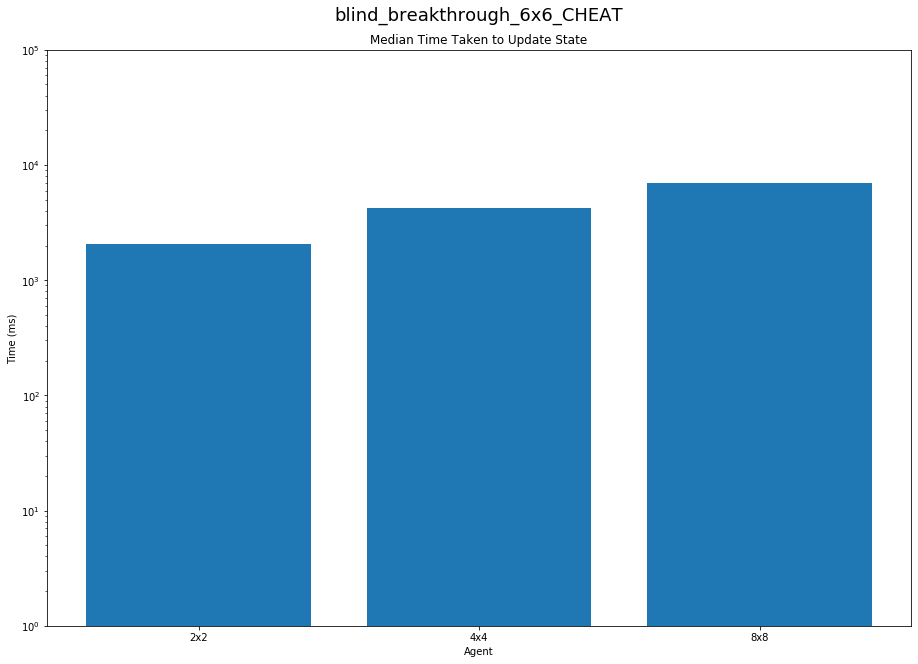

In [11]:
sum_game_median_state_update_times = list()
for idx, game_median_state_update_times in enumerate(median_state_update_times):
    sum_game_median_state_update_times.append(sum(game_median_state_update_times)/len(game_median_state_update_times))
    
# Put into graphs
fig = plt.figure()
fig.suptitle(str(data[0]['game_name'][0]), x=1, y=2.15, fontsize=18)

# Draw mean graph for State Update
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Median Time Taken to Update State')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Time (ms)')
ax1.set_yscale('log')
ax1.set_ylim([1,100000])
ax1.bar(numNames, sum_game_median_state_update_times)

plt.show()
    
# sum_game_mean_state_update_times

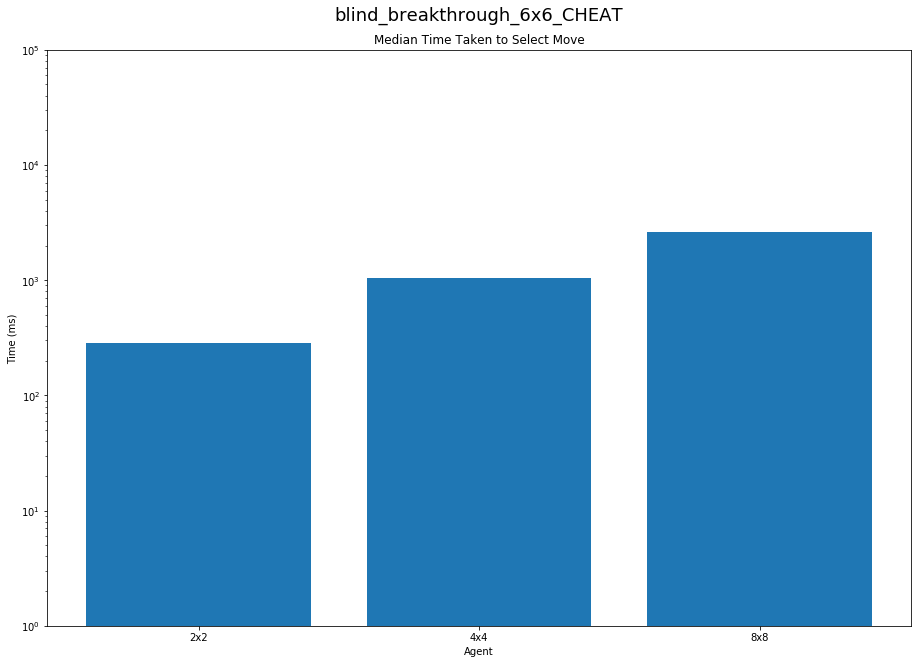

In [12]:
sum_game_median_move_select_times = list()
for idx, game_median_move_select_times in enumerate(median_move_select_times):
    sum_game_median_move_select_times.append(sum(game_median_move_select_times)/len(game_median_move_select_times))
    
# Put into graphs
fig = plt.figure()
fig.suptitle(str(data[0]['game_name'][0]), x=1, y=2.15, fontsize=18)

# Draw mean graph for State Update
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Median Time Taken to Select Move')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Time (ms)')
ax1.set_yscale('log')
ax1.set_ylim([1,100000])
ax1.bar(numNames, sum_game_median_move_select_times)

plt.show()
    
# sum_game_mean_state_update_times

## Hypergame Utilization

I will now consider how useful increasing the cap of hypergames was

In [14]:
max_hypergames = [2, 4, 8]

hypergame_utilization_sum = list()
hypergame_utilization_max = list()
hypergame_utilization_count = list()
hypergame_utilization = list()

fig = plt.figure()

for idx, move_list in enumerate(move_list_games):
    hypergame_utilization_sum.append([0] * max_num_steps[idx])
    hypergame_utilization_max.append([0] * max_num_steps[idx])
    hypergame_utilization_count.append([0] * max_num_steps[idx])
    hypergame_utilization.append([])

    # Count number of hypergames used on average at each step out of the maximum number
    for game in move_list:
        for index, row in game.iterrows():
            if(row['player_name'] == 'ahyperlt'):
                hypergame_utilization_sum[idx][row['step']] += row['count_hypergames']
                hypergame_utilization_count[idx][row['step']] += 1
                if(row['count_hypergames'] / max_hypergames[idx] > hypergame_utilization_max[idx][row['step']]):
                    hypergame_utilization_max[idx][row['step']] = row['count_hypergames'] / max_hypergames[idx]
    hypergame_utilization[idx] = [(utilSum / count) / max_hypergames[idx] for utilSum, count in zip(hypergame_utilization_sum[idx], hypergame_utilization_count[idx])]

    # display
    
    ax1 = fig.add_axes([0,-idx - idx*0.25,1,1])
    ax1.set_title('Average proportion of hypergame usage at each step for ' + str(numNames[idx]))
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Hypergame usage out of max of ' + str(max_hypergames[idx]))
    ax1.set_yscale('linear')
    ax1.set_yticks(np.linspace(0,1,11))
    ax1.set_ylim([0,1])
    ax1.bar(range(0, len(hypergame_utilization[idx])), hypergame_utilization[idx])

    ax2 = fig.add_axes([1.25,-idx  - idx*0.25,1,1])
    ax2.set_title('Maximum hypergame usage at each step for ' + str(numNames[idx]))
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Hypergame usage out of max of ' + str(max_hypergames[idx]))
    ax2.set_yscale('linear')
    ax2.set_yticks(np.linspace(0,1,11))
    ax2.set_ylim([0,1])
    ax2.bar(range(0, len(hypergame_utilization_max[idx])), hypergame_utilization_max[idx])

plt.show()

ZeroDivisionError: division by zero

<Figure size 432x288 with 0 Axes>

### Steps taken to win

2x2
	Mean steps to win: 36
	Median steps to win: 39.0
4x4
	Mean steps to win: 28
	Median steps to win: 29.5
8x8
	Mean steps to win: 31
	Median steps to win: 34.0


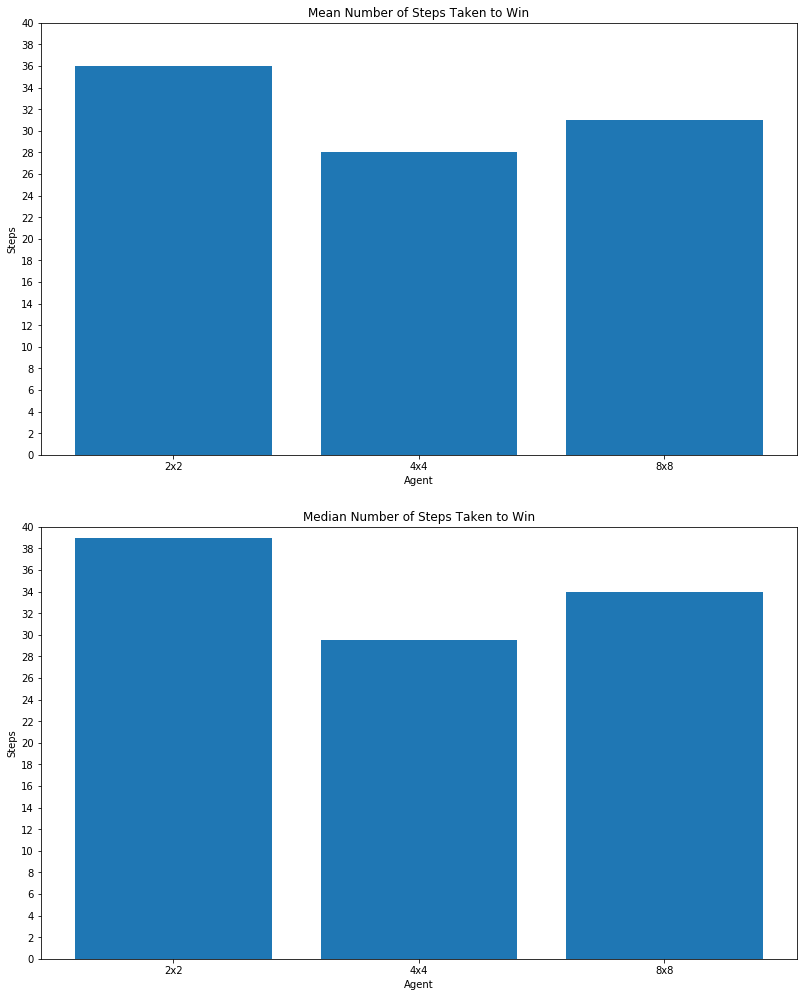

In [16]:
# Calculate the average number of steps taken to win for each hypergame
steps_to_win_list = list()
for idx, (move_list, game) in enumerate(zip(move_list_games, data)):
    game_steps_to_win_list = list()
    winning_games = game[((game['player_1_score'] == 100) & (game['player_2_score'] == 0)) | (len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)| (game['player_1_score'] == 50) & (game['player_2_score'] == 50)]))] 
    winning_games_list = winning_games['match_id'].tolist()
    for moves in move_list:
        if(moves['match_id'][0] in winning_games_list):
            move_length = len(moves['match_id'])
            game_steps_to_win_list.append(moves['step'][move_length - 1] + 1)
    steps_to_win_list.append(game_steps_to_win_list)

# Print steps to win
mean_steps_to_win = list()
median_steps_to_win = list()
for idx, game_steps_to_win in enumerate(steps_to_win_list):
    mean = statistics.mean(game_steps_to_win)
    median = statistics.median(game_steps_to_win)
    print(f'{numNames[idx]}')
    print(f'\tMean steps to win: {mean}')
    print(f'\tMedian steps to win: {median}')
    mean_steps_to_win.append(mean)
    median_steps_to_win.append(median)

# Graph steps to win
fig = plt.figure()
ax1 = fig.add_axes([0,0,1.75,1.5])
ax1.set_title('Mean Number of Steps Taken to Win')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Steps')
ax1.set_yscale('linear')
ax1.set_yticks(range(0,42,2))
ax1.set_ylim([0,40])
ax1.bar(numNames, mean_steps_to_win)

ax2 = fig.add_axes([0,-1.75,1.75,1.5])
ax2.set_title('Median Number of Steps Taken to Win')
ax2.set_xlabel('Agent')
ax2.set_ylabel('Steps')
ax2.set_yscale('linear')
ax2.set_yticks(range(0,42,2))
ax2.set_ylim([0,40])
ax2.bar(numNames, median_steps_to_win)

plt.show()